In [1]:
!pip install -q transformers sacremoses
!export TOKENIZERS_PARALLELISM = false

/bin/bash: line 0: export: `=': not a valid identifier


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import os
import pandas as pd


ROOT = '/content/drive/MyDrive/Colab Notebooks/ZUM/NLP/data'


train = pd.read_csv(os.path.join(ROOT, 'train.csv'), index_col=0)
valid = pd.read_csv(os.path.join(ROOT, 'valid.csv'), index_col=0)


train.head()

,user,text,date,language,text-normalized,label
167299,JakubMajmurek,"Mogłoby się wydawać, że wielkie protesty na je...",2021-03-13 09:04:53+00:00,pl,móc wydawać wielki protest jesień spadek sonda...,1
12664,lis_tomasz,To może jest niezły pomysł - uwolnić Polskę od...,2021-12-16 15:28:19+00:00,pl,niezły pomysł uwolnić Polska człowiek awansowa...,0
58983,WitoldGlowacki,"Strasznie się ucieszyłem, że Netflix wrzucił ""...",2018-09-13 20:01:17+00:00,pl,strasznie ucieszyć netflix wrzucić mountain fi...,0
131685,GadowskiWitold,"Jestem mężczyzną w mocno średnim wieku, całe ż...",2021-09-23 10:51:59+00:00,pl,mężczyzna mocno średni wieko cały żyto komuna ...,1
52477,WitoldGlowacki,Podsumujmy. Rządy Polski i Węgier aż tak bardz...,2020-11-16 18:53:16+00:00,pl,podsumować rząd Polska Węgry chcieć przestrzeg...,0


In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
tokenizer('Dzień dobry, Panie Bobrze').input_ids

[0, 8876, 6092, 1947, 3649, 10999, 2226, 2]

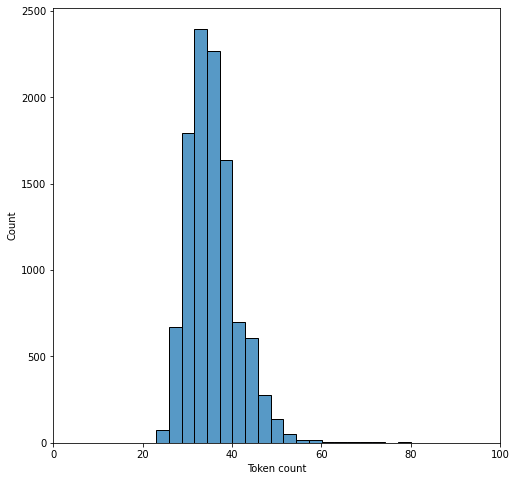

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


lengths = train['text-normalized'].apply(tokenizer.encode).apply(len)

plt.figure(figsize=(8, 8))
sns.histplot(lengths.tolist(), bins=20)
plt.xlim([0, 100]);
plt.xlabel('Token count')
plt.show()

In [6]:
from torch.utils.data import Dataset
from dataclasses import dataclass
from typing import Dict, Any, Sequence
import torch


@dataclass
class CustomDataset(Dataset):
  texts: Sequence[str]
  labels: Sequence[int]
  tokenizer: AutoTokenizer
  max_length: int = 100

  def __len__(self) -> int:
    return len(self.texts)

  def __getitem__(self, index: int) -> Dict[str, Any]:
    text = self.texts[index]
    label = self.labels[index]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_length,
      padding='max_length',
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'texts': text,
      'inputs': encoding.input_ids.flatten(),
      'masks': encoding.attention_mask.flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [7]:
from torch.utils.data import DataLoader
from pandas import DataFrame

def build_data_loader(data: DataFrame, batch_size: int = 128) -> DataLoader:
    texts = data['text-normalized'].tolist()
    labels = data['label'].tolist()

    dataset = CustomDataset(texts, labels, tokenizer)

    return DataLoader(dataset, batch_size, shuffle=True)


train_loader = build_data_loader(train, batch_size=16)
valid_loader = build_data_loader(valid, batch_size=16)

In [8]:
from transformers import AutoModelForSequenceClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('allegro/herbert-base-cased')
model = model.to(device)

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.sso.sso_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

In [9]:
from torch.optim import Optimizer
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import LambdaLR
from dataclasses import field
from typing import Tuple
from collections import defaultdict
from sklearn.metrics import accuracy_score

import numpy as np


@dataclass
class Trainer:
  model: AutoModelForSequenceClassification
  criterion: CrossEntropyLoss
  optimizer: Optimizer
  scheduler: LambdaLR
  epochs: int = 100
  epochs_per_evaluation: int = 1
  best_validation_score: float = 0.0
  metrics: Dict[str, Tuple] = field(default_factory=dict)
  model_directory_path: str = f'{ROOT}/models/'


  def train(self, train: DataLoader, valid: DataLoader) -> None:
    for epoch in range(1, self.epochs + 1):

      self.model.train()
      metrics = defaultdict(list)

      for batch in train: 
        self.optimizer.zero_grad()

        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)
        masks = batch['masks'].to(device)


        logits = self.model(inputs, masks).logits
        predictions = logits.argmax(1)


        loss = self.criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
        self.optimizer.step()


        metrics['losses'].append(loss.item())
        metrics['predictions'].extend(predictions.tolist())
        metrics['labels'].extend(labels.tolist())

      loss = np.mean(metrics['losses'])
      score = accuracy_score(metrics['labels'], metrics['predictions'])

      message = f'Epoch {epoch} | Loss {loss:.4f} | Accuracy: {score:.2f}'

      self.metrics[f'Epoch {epoch}'] = (loss, score)

      if epoch % self.epochs_per_evaluation == 0:
        loss, score = self.evaluate(valid)

        if score > self.best_validation_score:
          self.best_validation_score = score
          self.save_best_model()

        message += f' | Validation Loss {loss:.4f} | Validation Accuracy: {score:.2f}'
        self.metrics[f'Validation {epoch // self.epochs_per_evaluation}'] = (loss, score)

      print(message)

  def evaluate(self, loader: DataLoader, return_metrics: bool = False) -> Tuple:
    self.model.eval()
    metrics = defaultdict(list)

    for batch in loader:
      with torch.no_grad():
        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)
        masks = batch['masks'].to(device)

        logits = self.model(inputs, masks).logits
        loss = self.criterion(logits, labels)
        predictions = logits.argmax(1)

        metrics['losses'].append(loss.item())
        metrics['predictions'].extend(predictions.tolist())
        metrics['labels'].extend(labels.tolist())

    loss = np.mean(metrics['losses']).item()
    score = accuracy_score(metrics['labels'], metrics['predictions'])

    return (loss, score, metrics) if return_metrics else (loss, score)

  def save_best_model(self) -> None:
      self.model.save_pretrained(self.model_directory_path)
          

In [10]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss().to(device)

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=len(train_loader) * EPOCHS
)

In [11]:
trainer = Trainer(model, criterion, optimizer, scheduler, epochs=EPOCHS)
trainer.train(train_loader, valid_loader)

Epoch 1 | Loss 0.5485 | Accuracy: 0.72 | Validation Loss 0.5268 | Validation Accuracy: 0.75
Epoch 2 | Loss 0.4520 | Accuracy: 0.79 | Validation Loss 0.4985 | Validation Accuracy: 0.76
Epoch 3 | Loss 0.3576 | Accuracy: 0.85 | Validation Loss 0.5769 | Validation Accuracy: 0.76
Epoch 4 | Loss 0.2619 | Accuracy: 0.90 | Validation Loss 0.6745 | Validation Accuracy: 0.76
Epoch 5 | Loss 0.2198 | Accuracy: 0.93 | Validation Loss 1.1796 | Validation Accuracy: 0.75


In [12]:
test = pd.read_csv(os.path.join(ROOT, 'test.csv'), index_col=0)
test_loader = build_data_loader(test, batch_size=16)


trainer.model = model.from_pretrained(trainer.model_directory_path)
trainer.model = trainer.model.to(device)

loss, score, metrics = trainer.evaluate(test_loader, return_metrics=True)

Successfully saved losses to /content/drive/MyDrive/Colab Notebooks/ZUM/NLP/data/validation.png
Successfully saved confusion matrix to /content/drive/MyDrive/Colab Notebooks/ZUM/NLP/data/classification-report.txt
Successfully saved classification report to /content/drive/MyDrive/Colab Notebooks/ZUM/NLP/data/confusion_matrix.png


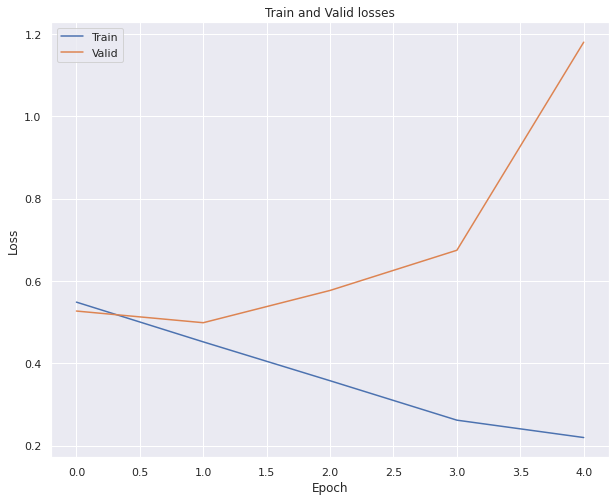

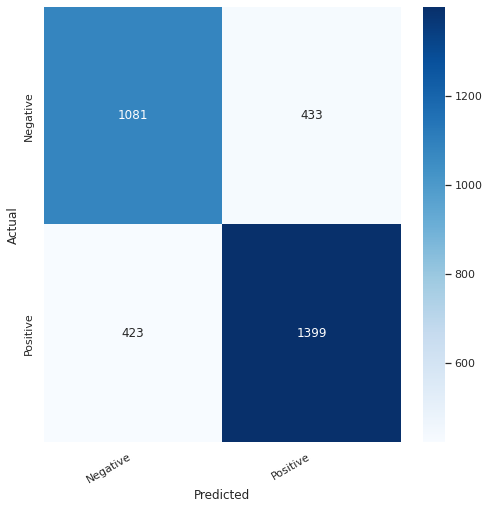

In [14]:
import sys

sys.path.append('/content/drive/MyDrive/Colab Notebooks/ZUM/NLP/')

import utils


labels, predictions = metrics['labels'], metrics['predictions']
names = ['Negative', 'Positive']

path = os.path.join(ROOT, 'validation.png')
utils.plot_losses(trainer.metrics, path)


path = os.path.join(ROOT, 'classification-report.txt')
utils.save_classification_report(labels, predictions, names, path)


path = os.path.join(ROOT, 'confusion_matrix.png')
utils.plot_confusion_matrix(labels, predictions, names, path) 